# Item Item Scorer

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from lenskit.basic import topn
from lenskit.knn import ItemKNNScorer
from lenskit.batch import recommend
from lenskit.data import from_interactions_df, ItemListCollection, UserIDKey
from lenskit.metrics import NDCG, RBP, RecipRank, RunAnalysis, Recall, Precision, RMSE, MAE
from lenskit.pipeline import topn_pipeline
from lenskit.splitting import SampleFrac, crossfold_users

Load data

In [2]:
df = pd.read_csv('../ALS/data/ratings.csv')
books_df = pd.read_csv('../ALS/data/books.csv')
dataset = from_interactions_df(df, user_col='user_id', item_col='book_id', rating_col='rating')

## Build ItemItem Model

Build model with default settings

In [3]:
model_ii = ItemKNNScorer(k=20)

In [4]:
pipe_ii = topn_pipeline(model_ii)

In [5]:
# test data is organized by user
all_test = ItemListCollection(UserIDKey)
# recommendations will be organized by model and user ID
all_recs = ItemListCollection(["model", "user_id"])

for split in crossfold_users(dataset, 5, SampleFrac(0.2)):
    # collect the test data
    all_test.add_from(split.test)

    # train the pipeline, cloning first so a fresh pipeline for each split
    fit_ii = pipe_ii.clone()
    fit_ii.train(split.train)
    ii_recs = recommend(fit_ii, split.test.keys(), 100)
    all_recs.add_from(ii_recs, model="II")

/opt/miniconda3/envs/dvC_env/lib/python3.13/site-packages/lenskit/data/relationships.py:378: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1741947719636/work/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(


In [6]:
ran = RunAnalysis()
ran.add_metric(NDCG())
ran.add_metric(RBP())
ran.add_metric(RecipRank())
results = ran.measure(all_recs, all_test)

In [8]:
results.list_metrics().mean()

NDCG         0.015468
RBP          0.007261
RecipRank    0.026249
dtype: float64

First Fine Tuning. Increase min neighbours from 1 to 3 and increase minimum similarity from 1e-06 to 0.1

In [9]:
model_ii = ItemKNNScorer(
    max_nbrs=20,              # 20 Nachbarn
    min_nbrs=3,            # Mindestens 3 Nachbarn
    min_sim=0.1             # Mindest-Ähnlichkeit
    )
pipe_ii = topn_pipeline(model_ii)

In [10]:
# test data is organized by user
all_test = ItemListCollection(UserIDKey)
# recommendations will be organized by model and user ID
all_recs = ItemListCollection(["model", "user_id"])

for split in crossfold_users(dataset, 5, SampleFrac(0.2)):
    # collect the test data
    all_test.add_from(split.test)

    # train the pipeline, cloning first so a fresh pipeline for each split
    fit_ii = pipe_ii.clone()
    fit_ii.train(split.train)
    ii_recs = recommend(fit_ii, split.test.keys(), 100)
    all_recs.add_from(ii_recs, model="II")

Tests mit k=10

In [ ]:
ran = RunAnalysis()
ran.add_metric(NDCG())
ran.add_metric(Precision())
ran.add_metric(Recall())
ran.add_metric(RBP())
ran.add_metric(RecipRank())
ran.add_metric(RMSE(missing_scores='ignore', missing_truth='ignore'))
ran.add_metric(MAE(missing_scores='ignore', missing_truth='ignore'))
results = ran.measure(all_recs, all_test)

In [20]:
results.list_metrics().mean()

NDCG@10         0.179640
Precision@10    0.179530
Recall@10       0.175635
RBP             0.170473
RecipRank       0.350592
RMSE            0.187708
MAE             0.050603
dtype: float64

Grid Search

In [4]:
# Schnelle Parameter-Suche
configs = [
    {"max_nbrs": 20, "min_nbrs": 3, "min_sim": 0.1},   # Current
    {"max_nbrs": 30, "min_nbrs": 5, "min_sim": 0.2},   # Konservativer
    {"max_nbrs": 50, "min_nbrs": 3, "min_sim": 0.15},  # Mehr Nachbarn
    {"max_nbrs": 40, "min_nbrs": 2, "min_sim": 0.05},  # Liberal

    # Zusätzliche Tests:
    {"max_nbrs": 10, "min_nbrs": 2, "min_sim": 0.3},   # Sehr konservativ
    {"max_nbrs": 100, "min_nbrs": 5, "min_sim": 0.1},  # Viele Nachbarn
    {"max_nbrs": 15, "min_nbrs": 1, "min_sim": 0.4},   # Hohe Ähnlichkeit
    {"max_nbrs": 80, "min_nbrs": 1, "min_sim": 0.01},  # Sehr liberal
    {"max_nbrs": 25, "min_nbrs": 3, "min_sim": 0.25},  # Balanced+
    {"max_nbrs": 60, "min_nbrs": 8, "min_sim": 0.15},  # Viele min_nbrs
]

for i, config in enumerate(configs):
    print(f"Testing config {i+1}: {config}")

    model_ii = ItemKNNScorer(**config)
    pipe_ii = topn_pipeline(model_ii)

    # test data is organized by user
    all_test = ItemListCollection(UserIDKey)
    # recommendations will be organized by model and user ID
    all_recs = ItemListCollection(["model", "user_id"])

    for split in crossfold_users(dataset, 1, SampleFrac(0.2)):
        # collect the test data
        all_test.add_from(split.test)

        # do the same for item-item
        fit_ii = pipe_ii.clone()
        fit_ii.train(split.train)
        ii_recs = recommend(fit_ii, split.test.keys(), 100)
        all_recs.add_from(ii_recs, model="II")
    
    ran = RunAnalysis()
    ran.add_metric(NDCG())
    ran.add_metric(RBP())
    ran.add_metric(RecipRank())
    ran.add_metric(Precision())
    ran.add_metric(Recall())
    results = ran.measure(all_recs, all_test)

    print(results.list_metrics().groupby("model").mean())

Testing config 1: {'max_nbrs': 20, 'min_nbrs': 3, 'min_sim': 0.1}


/opt/miniconda3/envs/dvC_env/lib/python3.13/site-packages/lenskit/data/relationships.py:378: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/miniforge3/conda-bld/libtorch_1741947719636/work/aten/src/ATen/SparseCsrTensorImpl.cpp:55.)
  return torch.sparse_csr_tensor(


           NDCG       RBP  RecipRank  Precision    Recall
model                                                    
II     0.237436  0.198387   0.395506   0.184912  0.269934
Testing config 2: {'max_nbrs': 30, 'min_nbrs': 5, 'min_sim': 0.2}
         NDCG       RBP  RecipRank  Precision    Recall
model                                                  
II     0.1116  0.135806   0.363094   0.284141  0.067372
Testing config 3: {'max_nbrs': 50, 'min_nbrs': 3, 'min_sim': 0.15}
           NDCG       RBP  RecipRank  Precision    Recall
model                                                    
II     0.197632  0.210053   0.471622   0.273778  0.166232
Testing config 4: {'max_nbrs': 40, 'min_nbrs': 2, 'min_sim': 0.05}
           NDCG       RBP  RecipRank  Precision    Recall
model                                                    
II     0.108927  0.035357   0.107426   0.043027  0.199847
Testing config 5: {'max_nbrs': 10, 'min_nbrs': 2, 'min_sim': 0.3}
           NDCG      RBP  RecipRank  Precisi

Config 1 ist vorzuziehen.

Top 3 Configs:
1. Config 1 max_nbrs=20, min_nbrs=3, min_sim=0.1

NDCG: 0.237 (Beste Ranking-Qualität)
Recall: 0.270 (Findet viele relevante Items)
Ausgewogene Performance

2. Config 3 max_nbrs=50, min_nbrs=3, min_sim=0.15

NDCG: 0.198, Precision: 0.274 (Hohe Precision)
Guter Kompromiss zwischen Qualität und Abdeckung

3. Config 5 max_nbrs=10, min_nbrs=2, min_sim=0.3

Precision: 0.357 (Beste Precision!)
Aber niedriger Recall (0.115)

Config 5 hat sich als die beste herausgestellt. Diese wird nun nochmal feinabgestimmt. \
`
{"max_nbrs": 25, "min_nbrs": 3, "min_sim": 0.25} 
NDCG@10: 0.2166 (+0.5% vs. bisherige beste) 
Precision@10: 0.2208 (beste) 
Recall@10: 0.2074 (beste) 
`

Neue Config für die Produktionsumgebung gewählt, da COnfig 12 eine zu geringe Coverage besitzt. 

In [9]:
model_ii = ItemKNNScorer(
    max_nbrs=30,              # 50 Nachbarn
    min_nbrs=3,               # Mindestens 3 Nachbarn
    min_sim=0.15              # Mindest-Ähnlichkeit
    )
pipe_ii = topn_pipeline(model_ii)
# pipe_ii.train(dataset)
# recs = recommend(pipe_ii, [234], 100)

In [10]:
# test data is organized by user
all_test = ItemListCollection(UserIDKey)
# recommendations will be organized by model and user ID
all_recs = ItemListCollection(["model", "user_id"])

for split in crossfold_users(dataset, 5, SampleFrac(0.2)):
    # collect the test data
    all_test.add_from(split.test)

    # train the pipeline, cloning first so a fresh pipeline for each split
    fit_ii = pipe_ii.clone()
    fit_ii.train(split.train)
    ii_recs = recommend(fit_ii, split.test.keys(), 100)
    all_recs.add_from(ii_recs, model="II")

2025-06-14 09:01:42 [warning  ] loaded pipeline does not match hash


/opt/miniconda3/envs/dvC_env/lib/python3.13/site-packages/lenskit/pipeline/_impl.py:233: PipelineWarning: loaded pipeline config does not match hash
  builder = PipelineBuilder.from_config(config)


2025-06-14 09:01:59 [warning  ] loaded pipeline does not match hash


/opt/miniconda3/envs/dvC_env/lib/python3.13/site-packages/lenskit/pipeline/_impl.py:233: PipelineWarning: loaded pipeline config does not match hash
  builder = PipelineBuilder.from_config(config)


2025-06-14 09:02:18 [warning  ] loaded pipeline does not match hash


/opt/miniconda3/envs/dvC_env/lib/python3.13/site-packages/lenskit/pipeline/_impl.py:233: PipelineWarning: loaded pipeline config does not match hash
  builder = PipelineBuilder.from_config(config)


2025-06-14 09:02:37 [warning  ] loaded pipeline does not match hash


/opt/miniconda3/envs/dvC_env/lib/python3.13/site-packages/lenskit/pipeline/_impl.py:233: PipelineWarning: loaded pipeline config does not match hash
  builder = PipelineBuilder.from_config(config)


2025-06-14 09:02:56 [warning  ] loaded pipeline does not match hash


/opt/miniconda3/envs/dvC_env/lib/python3.13/site-packages/lenskit/pipeline/_impl.py:233: PipelineWarning: loaded pipeline config does not match hash
  builder = PipelineBuilder.from_config(config)


In [11]:
ran = RunAnalysis()
ran.add_metric(NDCG())
ran.add_metric(Precision())
ran.add_metric(Recall())
ran.add_metric(RBP())
ran.add_metric(RecipRank())
results = ran.measure(all_recs, all_test)

print(results.list_metrics().groupby("model").mean())

           NDCG  Precision    Recall       RBP  RecipRank
model                                                    
II     0.218202   0.245904  0.201847  0.217651    0.47487


In [12]:
ran = RunAnalysis()

# Alle k-Werte von 1 bis 20 hinzufügen
k_values = range(1, 21)
for k in k_values:
    ran.add_metric(NDCG(k=k))
    ran.add_metric(Precision(k=k))
    ran.add_metric(Recall(k=k))
    ran.add_metric(RBP(k=k))
    ran.add_metric(RecipRank(k=k))

# Einmal ausführen für alle Metriken
results = ran.measure(all_recs, all_test)
df_results = results.list_metrics().groupby("model").mean()

print(df_results)

         NDCG@1  Precision@1  Recall@1     RBP@1  RecipRank@1    NDCG@2  \
model                                                                     
II     0.331218     0.331218  0.331218  0.049683     0.331218  0.312388   

       Precision@2  Recall@2     RBP@2  RecipRank@2  ...   NDCG@19  \
model                                                ...             
II        0.320465  0.312388  0.087111     0.404472  ...  0.208288   

       Precision@19  Recall@19    RBP@19  RecipRank@19   NDCG@20  \
model                                                              
II         0.258416   0.172147  0.214956      0.474132  0.206051   

       Precision@20  Recall@20    RBP@20  RecipRank@20  
model                                                   
II         0.257448   0.169795  0.215503      0.474244  

[1 rows x 100 columns]


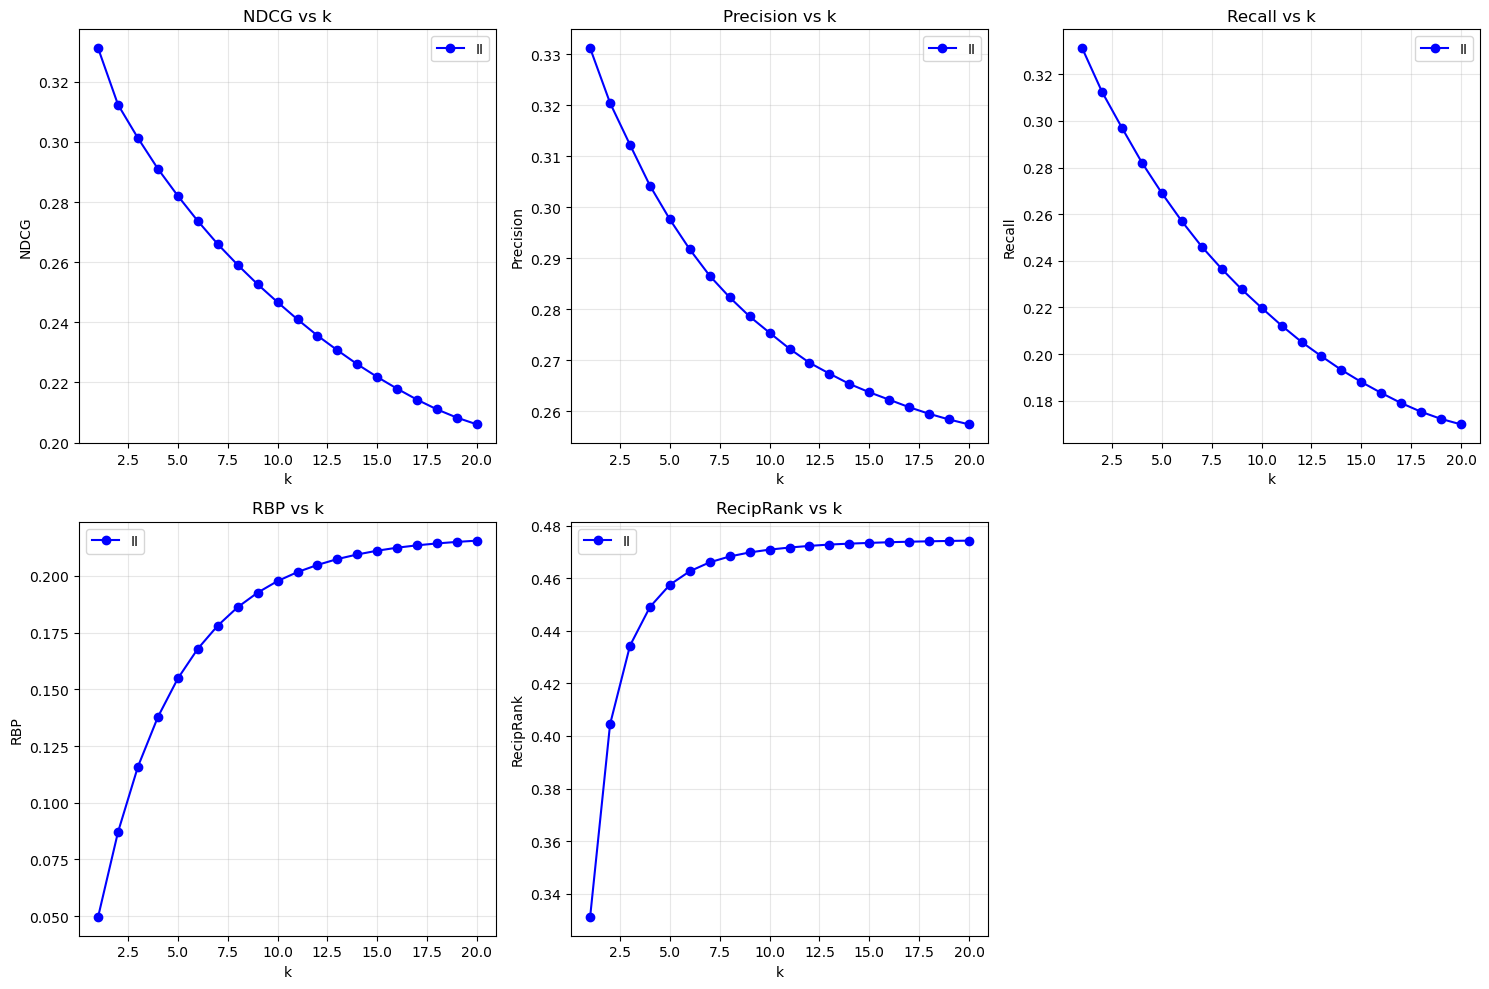

In [14]:
# Ergebnisse für Plotting strukturieren
def extract_metric_values(df, metric_name):
    """Extrahiert Werte einer Metrik für alle k-Werte"""
    metric_cols = [col for col in df.columns if col.startswith(f"{metric_name}@")]
    k_vals = [int(col.split('@')[1]) for col in metric_cols]
    
    # Sortiere nach k-Werten
    sorted_pairs = sorted(zip(k_vals, metric_cols))
    k_sorted = [pair[0] for pair in sorted_pairs]
    cols_sorted = [pair[1] for pair in sorted_pairs]
    
    return k_sorted, df[cols_sorted].values

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

metrics = ['NDCG', 'Precision', 'Recall', 'RBP', 'RecipRank']
colors = ['blue', 'red', 'green', 'orange', 'purple']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    k_vals, values = extract_metric_values(df_results, metric)
    
    # Plot für jedes Modell
    for model_idx, model in enumerate(df_results.index):
        ax.plot(k_vals, values[model_idx], 
                marker='o', label=f'{model}', 
                color=colors[model_idx % len(colors)])
    
    ax.set_xlabel('k')
    ax.set_ylabel(f'{metric}')
    ax.set_title(f'{metric} vs k')
    ax.legend()
    ax.grid(True, alpha=0.3)

# Letztes Subplot leer lassen oder für Gesamtvergleich nutzen
axes[-1].axis('off')

plt.tight_layout()
plt.show()